# Logistic Regression Capstone Project - Part 3

**=================================================================================================================**

## Project Description

The logistic regression tool that you have developed allows you to run a logistic regression with an individual predictor and summarize the model’s performance. Using this tool, investigate the performance of other predictors to determine which predictors appear to be the most informative. 

## Data Dictionary

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
|annual_inc |The self-reported annual income provided by the borrower during registration, in $1000s	|
|application_type |Indicates whether the loan is an individual application or a joint application with two co-borrowers	|
|collections_12_mths_ex_med |Number of collections in 12 months excluding medical collections	|
|delinq_2yrs |The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years	|
|dti |A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.	|
|home_ownership |The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.	|
|inq_last_6mths |The number of inquiries in past 6 months (excluding auto and mortgage inquiries)	|
|loan_status |Current status of the loan	|
|open_acc |The number of open credit lines in the borrower's credit file.	|
|pub_rec |Number of derogatory public records	|
|term |	The number of payments on the loan. Values are in months and can be either 36 or 60. |
|verification_status |Indicates if income was verified by LC, not verified, or if the income source was verified	|

## Summary

Using alpha (significance value) at 0.05, features are annual income, delinquency, inquiry, opened credit lines, number of public records, 60 mths term and verified status are most informative

**=================================================================================================================**

## Import Libraries

In [1]:
import numpy as np
from numpy import count_nonzero, median, mean
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import datetime
from datetime import datetime, timedelta, date

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

import scipy
from scipy import stats
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
from scipy.stats import boxcox
from collections import Counter

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures

from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.feature_selection import f_regression, f_classif, chi2, RFE, RFECV
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.feature_selection import VarianceThreshold, GenericUnivariateSelect
from sklearn.feature_selection import SelectFromModel, SelectKBest, SelectPercentile

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB

import imblearn

from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek


import feature_engine

from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures 
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection
from feature_engine.selection import SelectBySingleFeaturePerformance

import pycaret
from pycaret.classification import *

%matplotlib inline
#sets the default autosave frequency in seconds
%autosave 60 
sns.set_style('dark')
sns.set(font_scale=1.2)

plt.rc('axes', titlesize=9)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings('ignore')

# This module lets us save our models once we fit them.
# import pickle

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format','{:.2f}'.format)

random.seed(0)
np.random.seed(0)
np.set_printoptions(suppress=True)

Autosaving every 60 seconds


## Quick Data Glance

In [2]:
df = pd.read_csv("calibdata1.csv")

In [3]:
df.head()

,annualinc,collections,delinq,inq,openacc,dti,pubrec,individual,mortgage,rent,own,other,term60mths,vstatusverified,vstatusnotverified,lstatus
0,205.00,0,0,2,28,23.72,0,1,1,0,0,0,1,1,0,0
1,36.00,0,0,0,8,22.77,0,1,0,1,0,0,0,0,1,0
2,48.00,0,0,1,10,13.68,0,1,0,1,0,0,0,1,0,0
3,40.00,0,0,0,11,8.37,0,1,1,0,0,0,0,0,1,0
4,83.00,0,0,0,18,23.50,0,1,0,1,0,0,0,1,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49986 entries, 0 to 49985
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   annualinc           49986 non-null  float64
 1   collections         49986 non-null  int64  
 2   delinq              49986 non-null  int64  
 3   inq                 49986 non-null  int64  
 4   openacc             49986 non-null  int64  
 5   dti                 49986 non-null  float64
 6   pubrec              49986 non-null  int64  
 7   individual          49986 non-null  int64  
 8   mortgage            49986 non-null  int64  
 9   rent                49986 non-null  int64  
 10  own                 49986 non-null  int64  
 11  other               49986 non-null  int64  
 12  term60mths          49986 non-null  int64  
 13  vstatusverified     49986 non-null  int64  
 14  vstatusnotverified  49986 non-null  int64  
 15  lstatus             49986 non-null  int64  
dtypes: f

In [5]:
df.dtypes.value_counts()

int64      14
float64     2
dtype: int64

In [6]:
# Descriptive Statistical Analysis
df.describe(include="all")

,annualinc,collections,delinq,inq,openacc,dti,pubrec,individual,mortgage,rent,own,other,term60mths,vstatusverified,vstatusnotverified,lstatus
count,49986.00,49986.00,49986.00,49986.00,49986.00,49986.00,49986.00,49986.00,49986.00,49986.00,49986.00,49986.00,49986.00,49986.00,49986.00,49986.00
mean,76.31,0.01,0.32,0.70,11.59,17.99,0.19,1.00,0.50,0.40,0.10,0.00,0.30,0.38,0.32,0.07
std,62.81,0.13,0.87,1.01,5.29,8.22,0.67,0.02,0.50,0.49,0.29,0.01,0.46,0.48,0.46,0.25
min,6.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,47.00,0.00,0.00,0.00,8.00,11.83,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,65.00,0.00,0.00,0.00,11.00,17.53,0.00,1.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,90.00,0.00,0.00,1.00,14.00,23.66,0.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00
max,8253.00,5.00,27.00,33.00,58.00,39.99,63.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [7]:
df.lstatus.value_counts(normalize=True)

0   0.93
1   0.07
Name: lstatus, dtype: float64

In [8]:
df.shape

(49986, 16)

In [9]:
df.columns

Index(['annualinc', 'collections', 'delinq', 'inq', 'openacc', 'dti', 'pubrec', 'individual', 'mortgage', 'rent', 'own', 'other', 'term60mths', 'vstatusverified', 'vstatusnotverified', 'lstatus'], dtype='object')

**==================================================================================================================**

## Create a small dataset

In [10]:
df = df.sample(frac=0.25)

In [11]:
df.reset_index(drop=True, inplace=True)

In [12]:
df.head()

,annualinc,collections,delinq,inq,openacc,dti,pubrec,individual,mortgage,rent,own,other,term60mths,vstatusverified,vstatusnotverified,lstatus
0,50.00,0,0,0,7,16.83,0,1,1,0,0,0,0,0,0,0
1,68.00,0,0,1,12,16.01,0,1,0,1,0,0,0,0,1,0
2,80.00,0,0,0,12,20.28,0,1,0,1,0,0,0,0,1,0
3,62.00,0,0,0,8,17.50,0,1,1,0,0,0,0,0,0,0
4,97.30,0,0,1,10,12.14,0,1,0,1,0,0,1,1,0,0


In [13]:
df.shape

(12496, 16)

In [14]:
df.lstatus.value_counts()

0    11619
1      877
Name: lstatus, dtype: int64

**==================================================================================================================**

## Logistic Regression (StatsModel)

In [15]:
df.columns

Index(['annualinc', 'collections', 'delinq', 'inq', 'openacc', 'dti', 'pubrec', 'individual', 'mortgage', 'rent', 'own', 'other', 'term60mths', 'vstatusverified', 'vstatusnotverified', 'lstatus'], dtype='object')

In [16]:
df.shape

(12496, 16)

In [17]:
X = df.iloc[:,0:15]
y = df.iloc[:,15]

In [18]:
X.values, y.values

(array([[ 50.,   0.,   0., ...,   0.,   0.,   0.],
        [ 68.,   0.,   0., ...,   0.,   0.,   1.],
        [ 80.,   0.,   0., ...,   0.,   0.,   1.],
        ...,
        [ 96.,   0.,   0., ...,   1.,   1.,   0.],
        [115.,   0.,   0., ...,   0.,   1.,   0.],
        [ 70.,   0.,   1., ...,   1.,   0.,   0.]]),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [19]:
X = sm.add_constant(X)

In [20]:
logreg = sm.Logit(y, X).fit(maxiter=1000)

         Current function value: 0.246207
         Iterations: 1000


In [21]:
logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                lstatus   No. Observations:                12496
Model:                          Logit   Df Residuals:                    12481
Method:                           MLE   Df Model:                           14
Date:                Tue, 25 Jul 2023   Pseudo R-squ.:                 0.03110
Time:                        19:31:57   Log-Likelihood:                -3076.6
converged:                      False   LL-Null:                       -3175.4
Covariance Type:            nonrobust   LLR p-value:                 1.764e-34
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -24.4125   2.15e+06  -1.14e-05      1.000   -4.22e+06    4.21e+06
annualinc             -0.0065      0.001     -5.814      0.000      -0.009      -0.004
collections           -0.1110      0.283     -0.392      0.695      -0.666       0.444
delinq                 0.1004      0.038      2.627      0.009       0.025       0.175
inq                    0.2913      0.031      9.514      0.000       0.231       0.351
openacc               -0.0158      0.008     -2.081      0.037      -0.031      -0.001
dti                   -0.0004      0.005     -0.090      0.928      -0.010       0.009
pubrec                -0.1840      0.079     -2.321      0.020      -0.339      -0.029
individual            20.8911   3.44e+04      0.001      1.000   -6.73e+04    6.74e+04
mortgage               1.3124   2.15e+06    6.1e-07      1.000   -4.22e+06    4.22e+06
rent                   1.5444   2.15e+06   7.18e-07      1.000   -4.22e+06    4.22e+06
own                    1.4197   2.15e+06    6.6e-07      1.000   -4.22e+06    4.22e+06
other                -28.6890   1.31e+07  -2.19e-06      1.000   -2.57e+07    2.57e+07
term60mths             0.3798      0.078      4.897      0.000       0.228       0.532
vstatusverified       -0.3736      0.085     -4.375      0.000      -0.541      -0.206
vstatusnotverified    -0.2266      0.090     -2.519      0.012      -0.403      -0.050
======================================================================================
"""

### Explain the Statistics

Model : OLS : Ordinary Least Squares : One way to create a linear regression model. Minimize the dependent samples so you can estimate the unknown samples when creating a linear regression model.

Method : Least Squares : Fit data to the model by minimizing the residual samples

R-squared : Measure of how well the regression line approximates the data points. If .5 then that is a sign that half of the observed variation can be explained by the models inputs. 1 would be perfectly correlated. 

Adj, R-squared : Reflects the fit of the model. Values range from 0 to 1, where higher values indicate a good fit.

F-statistic : Measures how significantly the data points fit into the regression model by measuring variation of sample means. 

Prob (F-statistic) : Probability that the null hypothesis for the full model is true. Closer to zero the better the samples approach the model.

Log-Likelihood : The conditional probability that the observed data fits the model

AIC : Adjusts the log-likelihood based on the number of observations and complexity of the model. It focuses on the data points that best describe the data.

Df Residuals : Degrees of freedom of the residuals which is the difference between predicted values and the measured data.

BIC : We want a low BIC. It focuses on the shortest description of the data like AIC.

Df Model : Number of parameters in the model

Coefficient Constant : Is your Y intercept. If both dependent and independent coefficients are zero then the expected output would equal the constant coefficient.

Independent Coefficient : Represents the change of the independent variable per unit.

Standard Error : Accuracy of the coefficients

P>|t| : The P Value. A P Value less than .05 is considered statistically significant.

[.025 - .975] : Confidence Interval : Represents the range in which coefficients are likely to fall.

Omnibus : (D’Angostino’s test) : Establishes whether the samples come from a normally distributed population.

Durbin-Watson : Test to see if the errors are not independent. Used to find repeating patterns that may be obstructed by noise. Its value lies between 0 and 4. If greater than 2 this is a sign that relationships between two variables are going in opposite directions (negatively correlated). If less than 2 variables are positively correlated. 

Prob(Omnibus) : Probability of Omnibus

Jarque-Bera : Tests whether the samples match a normal distribution. It never has a negative number and the further it gets from zero signals the data doesn't have a normal distribution. 

Skew : Measure of the asymmetry of the probability distribution. Negative skew indicates the tail is longer on the left and the concentration of the data is on the right. Positive indicates the tail is longer on the right. 0 indicates that the tails are balanced.

Prob(JB) : The probability of Jarque-Bera

Kurtosis : Describes the shape of a probability distribution with a focus on the tails and not the peak. If the value is high that is a sign that there are more outliers. If the value is less than 3 that means there are fewer outliers. A value of 3 points towards a normal distribution. Values greater than 3 indicate more outliers.

Condition Number : Represents whether samples are highly related in our regression model. A large number indicates strong multicollinearity which means that independent variables are highly correlated with each other. This causes problems because a small number of samples are so dramatically different from others that results are corrupted.

**==================================================================================================================**

## Train Test Split

We've prepared our data and we're ready to model. There's one last step before we can begin. We must split the data into features and target variable, and into training data and test data. We do this using the `train_test_split()` function. We'll put 25% of the data into our test set, and use the remaining 75% to train the model.

Notice below that we include the argument `stratify=y`. If our master data has a class split of 80/20, stratifying ensures that this proportion is maintained in both the training and test data. `=y` tells the function that it should use the class ratio found in the `y` variable (our target).

The less data you have overall, and the greater your class imbalance, the more important it is to stratify when you split the data. If we didn’t stratify, then the function would split the data randomly, and we could get an unlucky split that doesn’t get any of the minority class in the test data, which means we wouldn’t be able to effectively evaluate our model. Worst of all, we might not even realize what went wrong without doing some detective work.

Lastly, we set a random seed so we and others can reproduce our work.

<img src="trin-test.png">

In [22]:
df.shape

(12496, 16)

In [23]:
X = df.iloc[:,0:15]
y = df.iloc[:,15]

In [24]:
Counter(y)

Counter({0: 11619, 1: 877})

In [25]:
X.values, y.values

(array([[ 50.,   0.,   0., ...,   0.,   0.,   0.],
        [ 68.,   0.,   0., ...,   0.,   0.,   1.],
        [ 80.,   0.,   0., ...,   0.,   0.,   1.],
        ...,
        [ 96.,   0.,   0., ...,   1.,   1.,   0.],
        [115.,   0.,   0., ...,   0.,   1.,   0.],
        [ 70.,   0.,   1., ...,   1.,   0.,   0.]]),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9996, 15), (2500, 15), (9996,), (2500,))

In [28]:
Counter(y_train), Counter(y_test)

(Counter({0: 9294, 1: 702}), Counter({0: 2325, 1: 175}))

**==================================================================================================================**

## Logistic Regression (Scikit Learn)

**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size

Let's build our model using **LogisticRegression** from the Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers. You can find extensive information about the pros and cons of these optimizers if you search it in the internet.

The version of Logistic Regression in Scikit-learn, support regularization. Regularization is a technique used to solve the overfitting problem of machine learning models.
**C** parameter indicates **inverse of regularization strength** which must be a positive float. Smaller values specify stronger regularization.

# Hyperparameter Tuning

## RandomSearchCV

Randomised grid search is very useful in finding near-optimal hyper parameters for any machine learning models.

Rules of thumb: with 60 iterations, 95% of the time, best 5% sets of parameters can be found, regardless of grid size.

In [29]:
logreg = LogisticRegression(max_iter=1000, random_state=0)

In [30]:
parameters = { 'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'penalty' : ['none', 'l1', 'l2', 'elasticnet'],
               'C':  [0.001, 0.01, 0.1, 1, 10, 100, 1000]
             }

In [31]:
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

In [32]:
lr_randm = RandomizedSearchCV(estimator=logreg, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring=scoring, refit='roc_auc', random_state=0)

In [33]:
%%time
lr_randm.fit(X_train, y_train)

CPU times: total: 3.12 s
Wall time: 1min 49s


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=0, refit='roc_auc',
                   scoring={'accuracy', 'recall', 'f1', 'precision', 'roc_auc'})

In [34]:
lr_randm.best_estimator_

LogisticRegression(C=0.1, max_iter=1000, random_state=0, solver='newton-cg')

In [35]:
lr_randm.best_score_

0.6249028742849245

In [36]:
lr_randm.best_params_

{'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}

In [37]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {
                 'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 'roc_auc' : 'mean_test_roc_auc'
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    roc_auc = best_estimator_results.mean_test_roc_auc
  
    # Create table of results
    table = pd.DataFrame()
    table = table.append({'Model': model_name,
                        'Precision': precision,
                        'Recall': recall,
                        'F1': f1,
                        'Accuracy': accuracy,
                        'ROC-AUC' : roc_auc
                        },
                        ignore_index=True
                       )
  
    return table

In [38]:
# Get all CV scores
lr_cv_results = make_results('Logistic Regression', lr_randm, 'roc_auc')
lr_cv_results

,Model,Precision,Recall,F1,Accuracy,ROC-AUC
0,Logistic Regression,0.00,0.00,0.00,0.93,0.62


### Logistic Regression model

In [39]:
logreg = LogisticRegression( penalty='l2', C=0.1, max_iter=1000, random_state=0, solver='lbfgs')

In [40]:
logreg.fit(X_train,y_train)

LogisticRegression(C=0.1, max_iter=1000, random_state=0)

In [41]:
logreg_pred = logreg.predict(X_test)

In [42]:
logreg_pred[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [43]:
logreg.coef_

array([[-0.00645173, -0.02134201,  0.11508702,  0.30393628, -0.00959703,
         0.00177016, -0.20658222,  0.11102757, -0.14985665,  0.10313881,
        -0.00774341,  0.        ,  0.36816719, -0.32598921, -0.20154292]])

In [44]:
logreg.intercept_

array([-2.33298616])

In [45]:
logreg.score(X_train, y_train)

0.929671868747499

In [46]:
logreg.score(X_test, y_test)

0.9304

### Logistic Model Evaluation

In [47]:
print(classification_report(y_test,logreg_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2325
           1       1.00      0.01      0.01       175

    accuracy                           0.93      2500
   macro avg       0.97      0.50      0.49      2500
weighted avg       0.94      0.93      0.90      2500



In [48]:
cm = confusion_matrix(y_test,logreg_pred)
cm

array([[2325,    0],
       [ 174,    1]], dtype=int64)

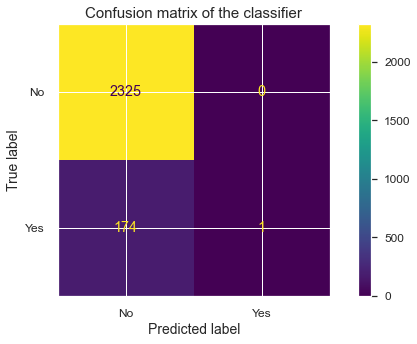

In [49]:
fig, ax = plt.subplots(figsize=(10,5))

ConfusionMatrixDisplay.from_estimator(estimator=logreg, X=X_test, y=y_test, ax=ax, display_labels=["No","Yes"])
ax.set_title('Confusion matrix of the classifier', size=15)

plt.show()

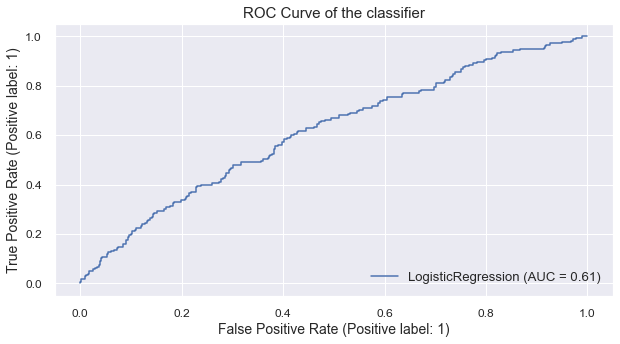

In [50]:
fig, ax = plt.subplots(figsize=(10,5))

RocCurveDisplay.from_estimator(estimator=logreg, X=X_test, y=y_test, ax=ax)
ax.set_title('ROC Curve of the classifier', size=15)

plt.show()

### Estimate the generalization error of a machine learning model using Cross-Validation Schemes

In [51]:
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [52]:
# estimate generalization error
clf = cross_validate(estimator=logreg,
                    X=X_train,
                    y=y_train,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=kf)

In [53]:
# mean test set roc-auc
clf["test_score"].mean()

0.6218615472715501

In [54]:
# mean train set roc-auc
clf["train_score"].mean()

0.6383161789183376

In [55]:
lrtable = pd.DataFrame()
lrtable = lrtable.append({'Model': "Logistic Regression",
                        'F1':  f1_score(y_test, logreg_pred),
                        'Recall': recall_score(y_test, logreg_pred),
                        'Precision': precision_score(y_test, logreg_pred),
                        'Accuracy': accuracy_score(y_test, logreg_pred),
                        'ROC-AUC': roc_auc_score(y_test, logreg_pred)
                      },
                        ignore_index=True)
                     
lrtable

,Model,F1,Recall,Precision,Accuracy,ROC-AUC
0,Logistic Regression,0.01,0.01,1.00,0.93,0.50


**==================================================================================================================**

**=================================================================================================================**

#### Python code done by Dennis Lam